# Preprocessing and feature extraction

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
from skimage.measure import label, regionprops, regionprops_table
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#show full pandas dataframe

pd.set_option("display.max_rows", None, "display.max_columns", None) 

In [4]:
#load data

df_ncrnet = pd.read_csv("Desktop/Feature extraction/with less features/ncrnet_fofeatures.csv")
df_ed = pd.read_csv("Desktop/Feature extraction/with less features/ed_fofeatures.csv")
df_et = pd.read_csv("Desktop/Feature extraction/with less features/et_forfeatures.csv")

df_survival_data = pd.read_csv('/Volumes/LaCie/Third semester DSS/Block 3/Thesis/data/survival_info.csv')
df_rp = pd.read_csv("Desktop/Feature extraction/df_regionprops.csv")
df_survival = df_survival_data.copy() #use copy of original survival dataset

# Exploratory Data Analysis

In [41]:
print("Shape of dataset:", df_survival.shape)

df_survival.head()

Shape of dataset: (236, 4)


,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [ ]:
df_survival.info()

In [ ]:
#only for numerical column

df_survival.describe()

In [ ]:
#Missing values in column: "Resection Status" = 107

df_survival.isnull().sum()

In [5]:
#create 'NA' group in 'Extent_of_Resection' column and use it as group

df_survival.Extent_of_Resection = df_survival.Extent_of_Resection.fillna("NA")
print(df_survival.shape)

(236, 4)


In [6]:
#drop patient ID 084 because of status 'ALIVE'
#drop patient ID 099 because no mask was found in segmentation (label 1)

df_survival = df_survival.drop(index=83, axis=1)
df_survival = df_survival.drop(index=98, axis=1)

print(df_survival.shape)

(234, 4)


In [7]:
#Set 'Survival_days' and 'Age' to numeric

df_survival["Survival_days"] = pd.to_numeric(df_survival["Survival_days"])
df_survival["Age"] = pd.to_numeric(df_survival["Age"])

In [8]:
#Bin continuous survival data in 2 and 3 groups

#Three-class classification #BraTS 2020 challenge

#short-term survivors = 0 up to 303 days (<10 months)
#mid-term survivors = 304 up to 455 (between 10 and 15 months)
#long-term survivors = 456 and up (>15 months)

#Two-class classification model

#short-term survivors = 0 up to 455 days (<15 months)
#long-term survivors = 456 and up (>15 months)

df_surv_2 = df_survival.copy()
df_surv_3 = df_survival.copy()

df_surv_3["Survival_group"] = pd.cut(df_surv_3.Survival_days.astype(int),bins=[0,303,455,1768],labels=['short-term','mid-term','long-term'])
df_surv_2["Survival_group"] = pd.cut(df_surv_2.Survival_days.astype(int),bins=[0,455,1768],labels=['short-term','long-term'])



/Users/b.vangurp/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


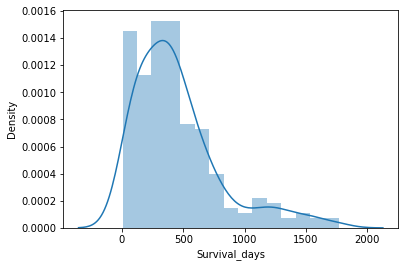

In [10]:
#right-skewed histogram

ax = sns.distplot(df_survival['Survival_days'], hist = True)
plt.show()

In [ ]:
display(df_survival)

# Feature extraction

In [ ]:
%%time

#PYRADIOMICS FEATURE EXTRACTION
#extracting PyRadiomics first order, shape, volume and texture features

#label 1: NCR/NET = necrotic and non-enhancing tumor --> visible in t2
#label 2: ED = edema                                 --> visible in T2-FLAIR
#label 4: ET = GD-enhancing tumor                    --> visible in t1ce

paramPath = ('/Volumes/LaCie/Third semester DSS/Block 3/Thesis/data/pyradiomics-master/examples/exampleSettings/Params.yaml')
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

case_id_list = ["001","002","003","004","005","006","007","008","009","010","011","012","013","014","015","016","017","018","019","020",
                "021","022","023","024","025","026","027","028","029","030","031","032","033","034","035","036","037","038","039","040",
                "041","042","043","044","045","046","047","048","049","050","051","052","053","054","055","056","057","058","059","060",
                "061","062","063","064","065","066","067","068","069","070","071","072","073","074","075","076","077","078","079","080",
                "081","082","083","085","086","087","088","089","090","091","092","093","094","095","096","097","098","100","101","102",
                "103","104","105","106","107","108","109","110","111","112","113","114","115","116","117","118","119","120","121","122",
                "123","124","125","126","127","128","129","145","147","151","152","153","154","157","158","159","160","161","162","163",
                "164","165","166","167","168","169","170","173","174","175","177","178","179","180","181","182","183","184","185","186",
                "187","188","189","190","191","192","194","195","196","199","201","203","204","206","210","214","215","216","217","218",
                "219","220","221","222","223","224","225","226","227","228","229","230","231","233","235","236","238","239","240","241",
                "242","246","247","249","250","251","252","253","254","255","337","338","339","340","341","342","345","346","347","348",
                "351","353","354","355","356","357","358","359","360","363","366","367","368","369"]

features = {}

i=0
for case_id in case_id_list:
    path = '/Volumes/LaCie/Third semester DSS/Block 3/Thesis/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}'.format(case_id, case_id)
    image = sitk.ReadImage(path + "_t2.nii.gz")
    mask = sitk.ReadImage(path + "_seg.nii.gz")
    features[case_id] = extractor.execute(image, mask)
    i+=1
    
# filter out everything but 'original_' features

# for key, val in features.items():
#     features[key]={}
#     for k,v in val.items():
#         if k.startswith("original_"):
#             features[key][k] = v


In [ ]:
#export features to pandas df and/or csv file

# pd.DataFrame.from_dict(features).T.to_csv("ncrnet_fffeatures.csv")


In [ ]:
#HANDCRAFTED FEATURE EXTRACTION
#Extracting region properties per tumor region (label 1,2,4) in segmentations


i=0
regionprops = {}
for case_id in id_list:
    result = {}
    path = '/Volumes/LaCie/Third semester DSS/Block 3/Thesis/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}'.format(case_id, case_id)
    mask = sitk.ReadImage(path + "_seg.nii.gz")
    mask = sitk.GetArrayFromImage(mask)
    result[case_id] = regionprops_table(mask, properties=('label','centroid','area',
                                                 'major_axis_length',
                                                 'minor_axis_length'))
    i+=1
    regionprops.update(result)


In [ ]:
#export features to pandas df and/or csv file

# df_rp.to_csv('df_regionprops.csv')

# Cleaning feature files

In [37]:
#add associated suffix to every column


df_ncrnet = df_ncrnet.add_suffix('_ncrnet')
df_ed = df_ed.add_suffix('_ed')
df_et = df_et.add_suffix('_et')

print(df_ncrnet.shape)
print(df_ed.shape)
print(df_et.shape)

(234, 77)
(234, 77)
(234, 77)


In [38]:
#merge 3 feature files to 1

df_raw_combined = pd.concat([df_ncrnet, df_ed, df_et], axis = 1, join = "inner")

print(df_raw_combined.shape)

(234, 231)


In [39]:
#drop unnecessary columns

df_raw_combined = df_raw_combined.drop(["Unnamed: 0_ncrnet"], axis = 1)
df_raw_combined = df_raw_combined.drop(["Unnamed: 0_ed"], axis = 1)
df_raw_combined = df_raw_combined.drop(["Unnamed: 0_et"], axis = 1)
df_raw_combined = df_raw_combined.drop(df_raw_combined.filter(regex='diagnostics_').columns, axis=1)

print(df_raw_combined.shape)

(234, 162)


In [ ]:
#list of all used patient cases

id_list = ["001","002","003","004","005","006","007","008","009","010","011","012","013","014","015","016","017","018","019","020",
                "021","022","023","024","025","026","027","028","029","030","031","032","033","034","035","036","037","038","039","040",
                "041","042","043","044","045","046","047","048","049","050","051","052","053","054","055","056","057","058","059","060",
                "061","062","063","064","065","066","067","068","069","070","071","072","073","074","075","076","077","078","079","080",
                "081","082","083","085","086","087","088","089","090","091","092","093","094","095","096","097","098","100","101",
                "102","103","104","105","106","107","108","109","110","111","112","113","114","115","116","117","118","119","120","121",
                "122","123","124","125","126","127","128","129","145","147","151","152","153","154","157","158","159","160","161","162",
                "163","164","165","166","167","168","169","170","173","174","175","177","178","179","180","181","182","183","184","185",
                "186","187","188","189","190","191","192","194","195","196","199","201","203","204","206","210","214","215","216","217",
                "218","219","220","221","222","223","224","225","226","227","228","229","230","231","233","235","236","238","239","240",
                "241","242","246","247","249","250","251","252","253","254","255","337","338","339","340","341","342","345","346","347",
                "348","351","353","354","355","356","357","358","359","360","363","366","367","368","369"]


In [47]:
#combine survival data with features file

df_combined = pd.concat([df_surv_3, df_raw_combined], axis = 1, join = "inner")

print(df_combined.shape)

(232, 167)


In [ ]:
#check for NaN values and in which column

df_combined.isnull().sum()

In [48]:
#export to pandas df and/or csv file

# df_combined.to_csv('Desktop/Feature extraction/with less features/df_all.csv')